In [2]:
from aizynthfinder.interfaces import AiZynthApp
from cgr_clustering.aizynth_converter import (
    extract_routes_from_tree, 
    filter_unique_routes,
    extract_pathway_aizynthfinder
)
from tqdm import tqdm
import pickle

2025-07-24 15:33:16.544802: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753363997.125214  747466 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753363997.240462  747466 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753363998.313535  747466 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753363998.313579  747466 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753363998.313583  747466 computation_placer.cc:177] computation placer alr

### Routes Generation

In [1]:
smiles = 'N#CC1(c2ccc(NC(=O)c3cccnc3NCc3ccncc3)cc2)CCCC1'

In [ ]:
# Load the AiZynthFinder application
app = AiZynthApp("config.yml")

### --- Route Extraction and Filtering ---

In [4]:
route_collections = extract_routes_from_tree(app)
print(f"Extracted {len(route_collections)} route collections.")
filtered_route_collection = filter_unique_routes(route_collections)
print(f"Filtered to {len(filtered_route_collection)} unique routes.")

Extracted 462 route collections.
Filtered to 127 unique routes.


### --- RouteCGR and SB-CGRs ---

In [5]:
from cgr_clustering.cgr import process_single_route, compose_all_sb_cgrs, route_smi_2_cgr

In [ ]:
# --- Pathway and CGR Conversion ---
def extract_route_cgr(filtered_route_collection):
    route_cgrs_dict = {}
    for i, data in tqdm(enumerate(filtered_route_collection)):
        try:
            root = data.dicts[0]
        except:
            root = data['dict']
        pathway = extract_pathway_aizynthfinder(root)
        cgr_pathway = route_smi_2_cgr(pathway, reverse=True)
        route_cgr = process_single_route(cgr_pathway) 
        route_cgrs_dict[i] = route_cgr
    return route_cgrs_dict

route_cgrs_dict = extract_route_cgr(filtered_route_collection)

# Save the generated RouteCGRs
# with open('route_cgrs_aizynth.pkl', 'wb') as f:
#     pickle.dump(route_cgrs_dict, f)

In [7]:
sb_cgrs_dict = compose_all_sb_cgrs(route_cgrs_dict)
len(sb_cgrs_dict)

127

In [8]:
from cgr_clustering.sb_clustering import group_by_strat_bonds

sbp_groups = group_by_strat_bonds(sb_cgrs_dict, use_strat=False)

In [9]:
len(sbp_groups)

20

In [9]:
sbp_groups

{'1.1': {'node_ids': [0, 26, 27, 30, 33, 34, 56, 57, 61, 62, 67],
  'sb_cgr': <CGRtools.containers.cgr.CGRContainer at 0x7f711b704040>,
  'strat_bonds': [(2, 25)],
  'group_size': 11},
 '2.1': {'node_ids': [24,
   25,
   28,
   29,
   31,
   32,
   41,
   42,
   49,
   50,
   52,
   53,
   55,
   58,
   63,
   64,
   65,
   68,
   69,
   70,
   71,
   74,
   75],
  'sb_cgr': <CGRtools.containers.cgr.CGRContainer at 0x7f711f692840>,
  'strat_bonds': [(9, 10), (17, 18)],
  'group_size': 23},
 '2.2': {'node_ids': [66],
  'sb_cgr': <CGRtools.containers.cgr.CGRContainer at 0x7f711f5ec540>,
  'strat_bonds': [(2, 4), (2, 25)],
  'group_size': 1},
 '2.3': {'node_ids': [35],
  'sb_cgr': <CGRtools.containers.cgr.CGRContainer at 0x7f711f693920>,
  'strat_bonds': [(1, 2), (9, 10)],
  'group_size': 1},
 '2.4': {'node_ids': [39, 40, 59, 60, 79, 80, 87, 88, 92, 93, 95, 96, 97, 106],
  'sb_cgr': <CGRtools.containers.cgr.CGRContainer at 0x7f711f693e20>,
  'strat_bonds': [(9, 10), (18, 19)],
  'group_si

In [10]:
from IPython.display import SVG, display

for i, group in sbp_groups.items():
    print(i)
    sb_cgr = group['sb_cgr']
    sb_cgr.clean2d()
    display(SVG(sb_cgr.depict()))


1.1


2.1


2.2


2.3


2.4


3.1


3.2


3.3


3.4


3.5


4.1


3.6


4.2


4.3


4.4


4.5


4.6


5.1


5.2


5.3


### Fixing the mismapping output - SKIP this part if mapping is okay

In [12]:
arom_amine = sbp_groups['5.3']['sb_cgr'].substructure([2,3,7,8], as_query=True)
arom_amine

In [12]:
l = sbp_groups['4.2']['sb_cgr'].substructure([6,7,8,18], as_query=True)
l

In [13]:
from cgr_clustering.sb_clustering import merge_groups, fix_dict_key_order

# Error mapped fixing
error_clusters = []
for i, group in sbp_groups.items():
    # print(i)
    sb_cgr = group['sb_cgr']
    sb_cgr.clean2d()
    # display(SVG(sb_cgr.depict()))
    if sb_cgr > arom_amine:
        error_clusters.append(i)
        # for j, group in sbp_groups.items():
        #     # if j != i and group['sb_cgr'] > arom_amine:
        #         new_groups = merge_groups(sbp_groups, j, i)

        # print(f"Error clusters: {error_clusters}")

        # Manually
        # if i == '5.3':
        #     new_groups = merge_groups(sbp_groups, '4.2', '5.3')
        # if i == '4.3':
        #     new_groups_2 = merge_groups(new_groups, '3.2', '4.3')
        # if i == '4.1':
        #     new_groups_3 = merge_groups(new_groups_2, '3.3', '4.1')
        # if i == '3.4':
        #     new_groups_3['2.5'] = new_groups_3['3.4']
        #     del new_groups_3['3.4']
clean_sbp_clusters = sbp_groups.copy()
if len(error_clusters) > 0:
    new_groups = merge_groups(sbp_groups, '4.2', '5.3')
    new_groups_2 = merge_groups(new_groups, '3.2', '4.3')
    new_groups_3 = merge_groups(new_groups_2, '3.3', '4.1')
    new_groups_3['2.5'] = new_groups_3['3.4']
    del new_groups_3['3.4']
    clean_sbp_clusters = fix_dict_key_order(new_groups_3)

print(clean_sbp_clusters)


Renamed keys:
  3.5 → 3.4
  3.6 → 3.5
  4.2 → 4.1
  4.4 → 4.2
  4.5 → 4.3
  4.6 → 4.4
{'1.1': {'node_ids': [0, 26, 27, 30, 33, 34, 56, 57, 61, 62, 67], 'sb_cgr': <CGRtools.containers.cgr.CGRContainer object at 0x7fe4207aef20>, 'strat_bonds': [(2, 25)], 'group_size': 11}, '2.1': {'node_ids': [24, 25, 28, 29, 31, 32, 41, 42, 49, 50, 52, 53, 55, 58, 63, 64, 65, 68, 69, 70, 71, 74, 75], 'sb_cgr': <CGRtools.containers.cgr.CGRContainer object at 0x7fe4207af380>, 'strat_bonds': [(9, 10), (17, 18)], 'group_size': 23}, '2.2': {'node_ids': [66], 'sb_cgr': <CGRtools.containers.cgr.CGRContainer object at 0x7fe4207af420>, 'strat_bonds': [(2, 4), (2, 25)], 'group_size': 1}, '2.3': {'node_ids': [35], 'sb_cgr': <CGRtools.containers.cgr.CGRContainer object at 0x7fe4207af4c0>, 'strat_bonds': [(1, 2), (9, 10)], 'group_size': 1}, '2.4': {'node_ids': [39, 40, 59, 60, 79, 80, 87, 88, 92, 93, 95, 96, 97, 106], 'sb_cgr': <CGRtools.containers.cgr.CGRContainer object at 0x7fe4207af560>, 'strat_bonds': [(9, 10),

### Clustering Timing Comparison

In [ ]:
from cgr_clustering.timing import multitime_run, multitime_ted_cluster, plot_results

sizes = [20, 40, 60, 80, 100, 120]
# Run the clustering with different sizes fro SB-CGRs
times_sizes_sb = multitime_run(filtered_route_collection, sizes, ntries=5)
# Run the clustering with different sizes fro TED
times_sizes_ted = multitime_ted_cluster(filtered_route_collection, sizes, ntries=5)

20it [00:08,  2.43it/s]
20it [00:07,  2.53it/s]
20it [00:10,  1.99it/s]
20it [00:08,  2.43it/s]
20it [00:07,  2.54it/s]


Size 20:
  • extract_route_cgr:    8.4540 s
  • compose_all_sb_cgrs:   0.0593 s
  • last section (sec3):   0.0197 s
  • total (start→end):     8.5330 s
----------------------------------------


40it [00:17,  2.25it/s]
40it [00:19,  2.08it/s]
40it [00:17,  2.25it/s]
40it [00:17,  2.25it/s]
40it [00:17,  2.28it/s]


Size 40:
  • extract_route_cgr:    18.0422 s
  • compose_all_sb_cgrs:   0.1116 s
  • last section (sec3):   0.0362 s
  • total (start→end):     18.1900 s
----------------------------------------


60it [00:24,  2.46it/s]
60it [00:24,  2.43it/s]
60it [00:25,  2.34it/s]
60it [00:24,  2.41it/s]
60it [00:23,  2.50it/s]


Size 60:
  • extract_route_cgr:    24.7141 s
  • compose_all_sb_cgrs:   0.1655 s
  • last section (sec3):   0.0558 s
  • total (start→end):     24.9354 s
----------------------------------------


80it [00:30,  2.63it/s]
80it [00:29,  2.71it/s]
80it [00:32,  2.48it/s]
80it [00:30,  2.67it/s]
80it [00:29,  2.75it/s]


Size 80:
  • extract_route_cgr:    30.2686 s
  • compose_all_sb_cgrs:   0.2188 s
  • last section (sec3):   0.0664 s
  • total (start→end):     30.5538 s
----------------------------------------


100it [00:39,  2.55it/s]
100it [00:40,  2.46it/s]
100it [00:39,  2.54it/s]
100it [00:38,  2.60it/s]
100it [00:39,  2.51it/s]


Size 100:
  • extract_route_cgr:    39.4883 s
  • compose_all_sb_cgrs:   0.2660 s
  • last section (sec3):   0.0828 s
  • total (start→end):     39.8371 s
----------------------------------------


120it [00:44,  2.70it/s]
120it [00:49,  2.45it/s]
120it [00:45,  2.63it/s]
120it [00:48,  2.49it/s]
120it [00:47,  2.52it/s]


Size 120:
  • extract_route_cgr:    46.9513 s
  • compose_all_sb_cgrs:   0.3248 s
  • last section (sec3):   0.1023 s
  • total (start→end):     47.3784 s
----------------------------------------


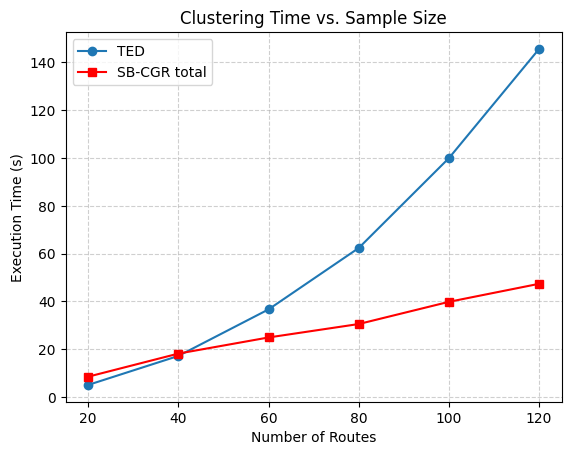

In [77]:
import matplotlib.pyplot as plt

def plot_results(sizes, times_sizes_ted, times_sizes_sb):
    # Plot
    plt.figure()
    plt.plot(sizes, list(times_sizes_ted), marker='o', label='TED')
    plt.plot(sizes, list(times_sizes_sb), marker='s', color='red', label='SB-CGR total')

    # Labels and title
    plt.xlabel('Number of Routes')
    plt.ylabel('Execution Time (s)')
    plt.title('Clustering Time vs. Sample Size')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Show the plot
    plt.show()

plot_results(sizes, times_sizes_ted, times_sizes_sb)


### Results overlaping Comparison

In [60]:
from collections import defaultdict

cluster_arr = filtered_route_collection.cluster(len(clean_sbp_clusters), distances_model="ted")
cluster_ted = defaultdict(list)
for idx, val in enumerate(cluster_arr):
    cluster_ted[val+1].append(idx)

Adjusted Rand Index (ARI): 0.0723
Normalized Mutual Information (NMI): 0.4456
Entropy first: 2.4514
Entropy second: 1.4782
Mutual Information: 0.8755
Variation of Information (VI): 2.1785

[(0, 12, 0.08333333333333333), (1, 4, 0.17391304347826086), (2, 10, 0.0), (3, 15, 0.0), (4, 5, 0.17857142857142858), (6, 2, 0.6666666666666666), (7, 1, 0.19753086419753085), (8, 17, 0.14285714285714285), (9, 11, 0.3), (10, 7, 0.2), (11, 8, 0.5), (12, 3, 0.0), (13, 14, 0.0), (14, 16, 1.0), (15, 6, 1.0), (16, 9, 0.0), (5, 13, 0.0)]


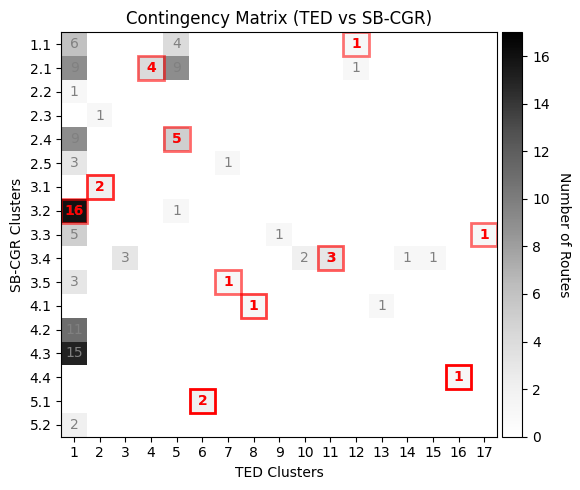

In [ ]:
from cgr_clustering.comparing import compute_contingency_matrix, display_contingency_matrix, match_clusters, calculate_similarity_metrics

y_true, y_pred = calculate_similarity_metrics(clean_sbp_clusters, cluster_ted)
cm = compute_contingency_matrix(y_true, y_pred)
# print("Contingency matrix:")
# print(cm, "\n")

matched, avg_jaccard = match_clusters(clean_sbp_clusters, cluster_ted)
display_contingency_matrix(clean_sbp_clusters, cluster_ted, matched, cm, method='TED')

### Explore routes by IDs

Need to run image generetaion (might take a while)

In [66]:
images = filtered_route_collection.make_images()

In [74]:
from cgr_clustering.comparing import contingency_nodes

sb_cgr_ind = '5.1'
ted_ind = 6
routes_list = contingency_nodes(clean_sbp_clusters, cluster_ted, sb_cgr_ind, ted_ind) 
print(len(routes_list))
print(routes_list)


2
[19, 20]


19


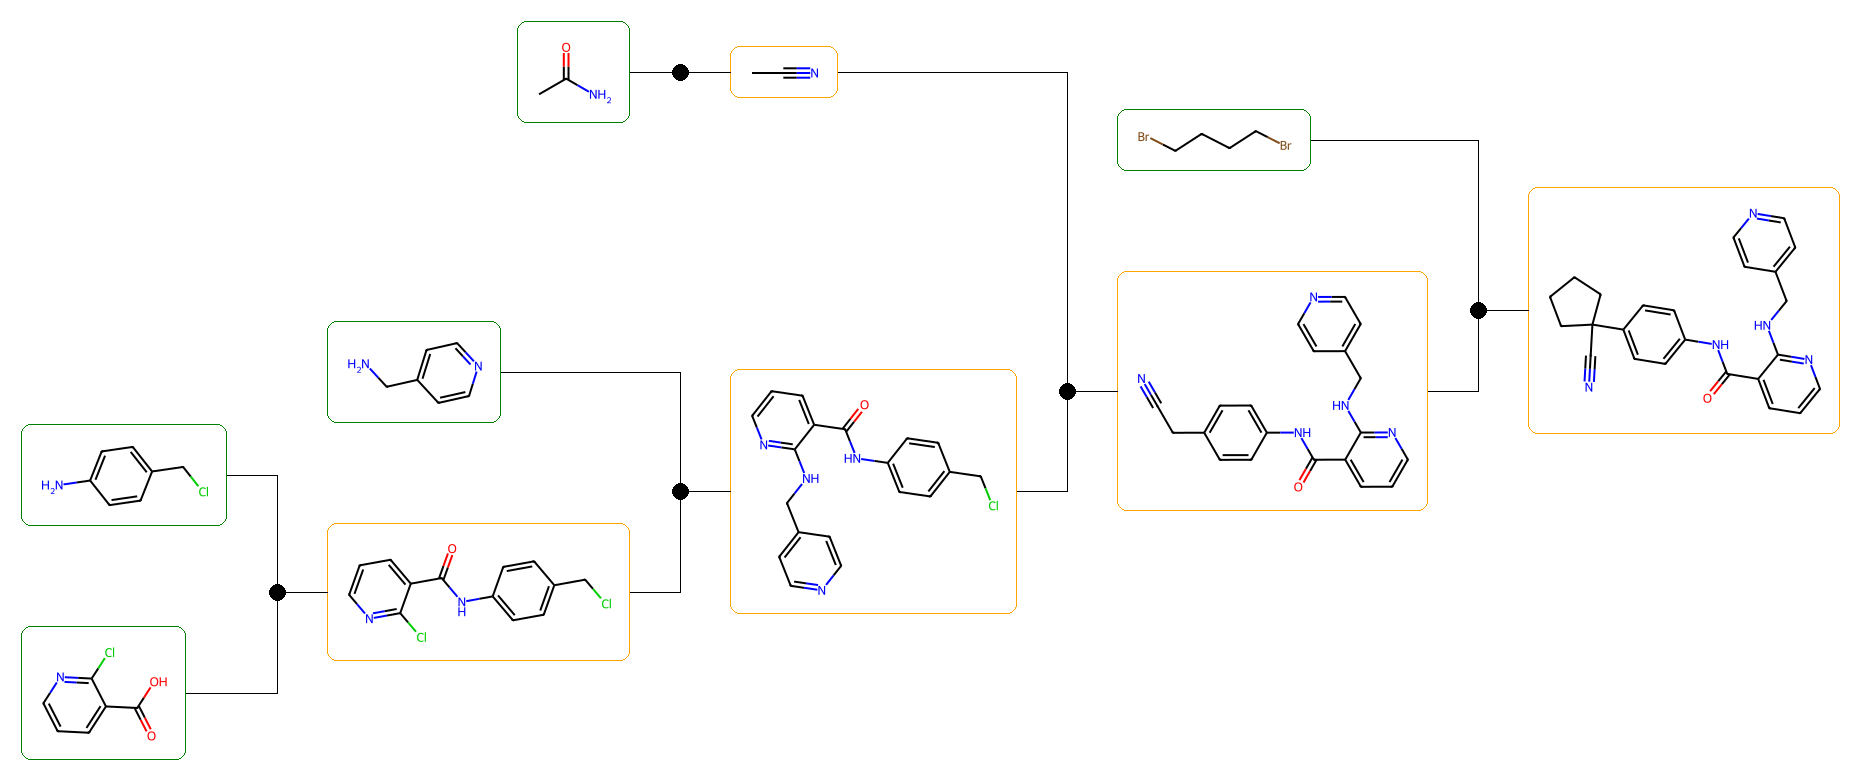

20


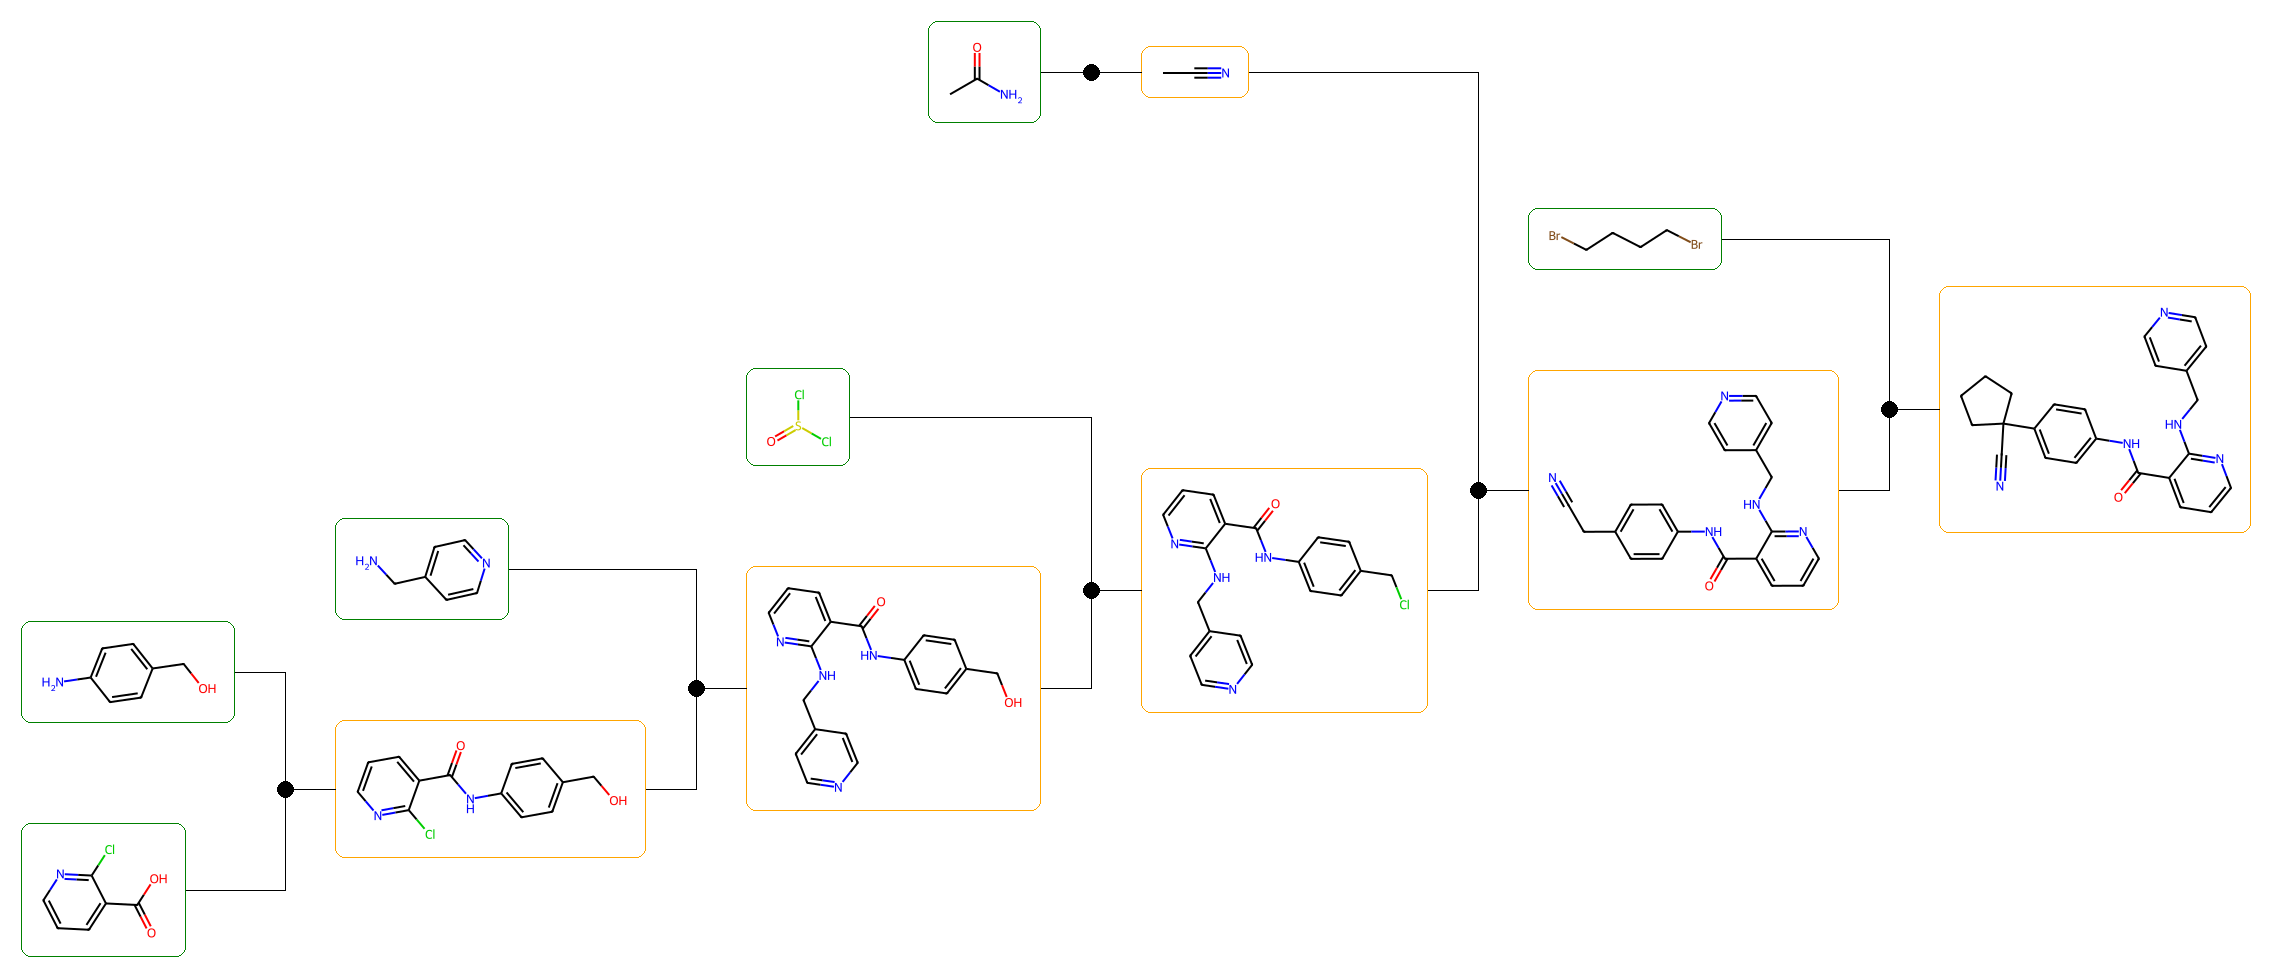

In [75]:
for route in routes_list:
    print(route)
    # display(route_collections[route].make_images()[0])
    display(images[route])

In [14]:
clean_sbp_clusters

{'1.1': {'node_ids': [0, 26, 27, 30, 33, 34, 56, 57, 61, 62, 67],
  'sb_cgr': <CGRtools.containers.cgr.CGRContainer at 0x7fe4207aef20>,
  'strat_bonds': [(2, 25)],
  'group_size': 11},
 '2.1': {'node_ids': [24,
   25,
   28,
   29,
   31,
   32,
   41,
   42,
   49,
   50,
   52,
   53,
   55,
   58,
   63,
   64,
   65,
   68,
   69,
   70,
   71,
   74,
   75],
  'sb_cgr': <CGRtools.containers.cgr.CGRContainer at 0x7fe4207af380>,
  'strat_bonds': [(9, 10), (17, 18)],
  'group_size': 23},
 '2.2': {'node_ids': [66],
  'sb_cgr': <CGRtools.containers.cgr.CGRContainer at 0x7fe4207af420>,
  'strat_bonds': [(2, 4), (2, 25)],
  'group_size': 1},
 '2.3': {'node_ids': [35],
  'sb_cgr': <CGRtools.containers.cgr.CGRContainer at 0x7fe4207af4c0>,
  'strat_bonds': [(1, 2), (9, 10)],
  'group_size': 1},
 '2.4': {'node_ids': [39, 40, 59, 60, 79, 80, 87, 88, 92, 93, 95, 96, 97, 106],
  'sb_cgr': <CGRtools.containers.cgr.CGRContainer at 0x7fe4207af560>,
  'strat_bonds': [(9, 10), (18, 19)],
  'group_si

### For inter-comparison with other retorysnthteic tools' results (SynPlanner and ASKCOS)

In [15]:
pickle.dump(clean_sbp_clusters, open('aizynth_clusters.pkl', 'wb'))